In [2]:
from google.colab import drive
drive.mount('/content/datasets')

Mounted at /content/datasets


In [3]:
import os, shutil

# original_dataset_dir = "./datasets/dogs-vs-cats/train"
base_dir = "/content/datasets/MyDrive/cats_and_dogs_small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(validation_dir, 'cats')
val_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

### 데이터 증식

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

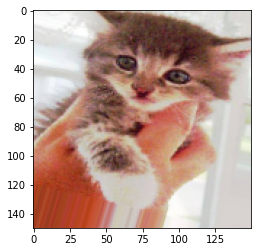

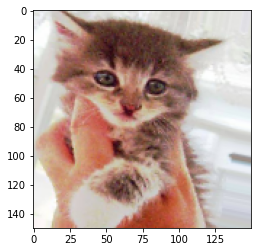

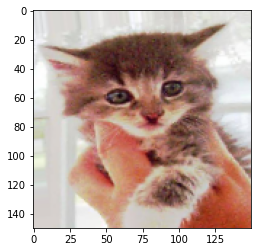

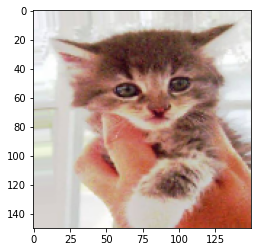

In [6]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

fnames = sorted([os.path.join(train_cats_dir, fname) for 
                 fname in os.listdir(train_cats_dir)])

# index 3의 이미지를 증식한다
img_path = fnames[3]

# 이미지를 읽어서 크기 변경
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환
x = image.img_to_array(img)
#(1, 150, 150, 3) 크기로 변환
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

### 드롭아웃

In [7]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# 검증 데이터는 증식 금지
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
62/62 - 538s - loss: 0.6931 - acc: 0.5055 - val_loss: 0.6859 - val_acc: 0.5000
Epoch 2/100
62/62 - 116s - loss: 0.6825 - acc: 0.5495 - val_loss: 0.6677 - val_acc: 0.5650
Epoch 3/100
62/62 - 116s - loss: 0.6766 - acc: 0.5590 - val_loss: 0.6716 - val_acc: 0.5600
Epoch 4/100
62/62 - 115s - loss: 0.6659 - acc: 0.5825 - val_loss: 0.6625 - val_acc: 0.5700
Epoch 5/100
62/62 - 116s - loss: 0.6616 - acc: 0.5850 - val_loss: 0.6459 - val_acc: 0.6210
Epoch 6/100
62/62 - 116s - loss: 0.6514 - acc: 0.6005 - val_loss: 0.6729 - val_acc: 0.5690
Epoch 7/100
62/62 - 116s - loss: 0.6368 - acc: 0.6245 - val_loss: 0.6076 - val_acc: 0.6660
Epoch 8/100
62/62 - 117s - loss: 0.6194 - acc: 0.6405 - val_loss: 0.6132 - val_acc: 0.6630
Epoch 9/100
62/62 - 117s - loss: 0.6107 - acc: 0.6655 - val_loss: 0.6078 - val_acc: 0.6470
Epoch 10/100
62/62 - 116s - loss: 0.5959 - acc: 0.6790 - val_loss: 0.5836 - val_acc: 0.6860
Epoch

In [9]:
validation_generator.samples, validation_generator.batch_size

(1000, 32)

In [10]:
model.save('cats_and_dogs_small_2.h5')

### 모델 훈련 및 훈련의 정확도, 손실 그래프

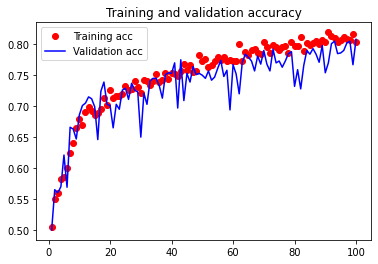

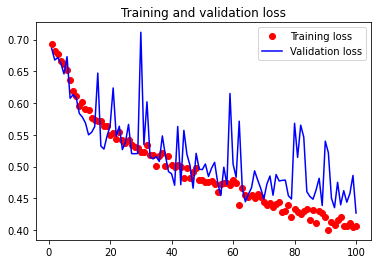

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()